# Automated inference with PyMC

We implement the same model as in the previous class but this time using the PyMC library. PyMC is a very powerful library with a lot of functionality and we will spend much of this course learning how to use PyMC effectively and how the algorithms behind automated inference work. We gloss over many of these details today to focus on the basic code needed for using PyMC and demonstrating that it actually does what it is supposed to.

## Tasks

Other than this workbook, there are no readings for today. The main goal today is to go through every line of code below in detail, to understand what each line does, and to clear up any questions you might have. We will use PyMC in almost every lesson after this one.

Feel free to discuss this pre-class work with other students in the course, or attempt it on your own if you prefer.

## PyMC on Forum, Google Colab, and your laptop

* Unfortunately, Forum doesn't provide enough computational resources to run PyMC effectively.
* The recommended way to run the pre-class workbooks is to use Google Colab. It is free to use, has all the necessary libraries pre-installed, and is automatically saved to your Google account.
* On your laptop, you need to install the PyMC library using `pip install pymc`. There are some more details (but not much more) in the [PyMC documentation](https://www.pymc.io/projects/docs/en/latest/installation.html). You will also need [Anaconda](https://www.anaconda.com/) already installed before installing PyMC.

In [2]:
# This is the standard naming convention for PyMC, abbreviating it to `pm`
import pymc as pm

# We still need NumPy for creating and computing with arrays
import numpy as np

# We won't use SciPy much after today, but today we use it to compare our
# solutions (posteriors) from the previous lesson with the solutions we get
# from PyMC.
import scipy.stats as sts

# Making plots
import matplotlib.pyplot as plt

## Review

In CS114, we covered the basics of Bayesian inference, which we assume you know for today.

The core idea is that Bayesian inference combines prior beliefs about an unknown variable (which we model using a random variable) with observed data to update our uncertainty. This updating is formalized by Bayes’ rule:

$$\begin{align}
\text{posterior} &= \,\frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}} \\
P(\theta\,|\,D) &= \,\frac{P(D \,|\, \theta) \, P(\theta)}{P(D)}\end{align}$$

* **Prior:** Represents what we believe about a parameter ($\theta$) before seeing data ($D$). Priors can come from past experiments, domain knowledge, past experience, or be uninformative if little is known.

* **Likelihood:** Captures how probable the observed data ($D$) are under different parameter values ($\theta$). It comes directly from the model of the data-generating process (for example, Binomial for dice rolls, Poisson for traffic counts).

* **Marginal likelihood (or evidence):** Represents the total probability (marginalized over all possible parameter values, $\theta$) of the data under this model. This is useful when comparing different models to see which model best fits the data.

* **Posterior:** The updated distribution over the parameter ($\theta$) after seeing data ($D$). It reflects both prior beliefs and additional information from the likelihood.

* **Credible interval:** The posterior can be used to compute credible intervals, for example, we are 95% confident $\theta \in [0.14, 0.29]$. Unlike frequentist confidence intervals, a Bayesian credible interval has a direct probability meaning: given the data, there is a 95% probability the parameter lies within that interval.

Describe the prior, likelihood, and posterior of the medical trial model we started in the previous class. (You can also see it below in the _Model_ section.) What is the interpretation of each of these three components — what does each component tell us about the medical trial scenario?

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

## Data

We use the same data set as in the previous lesson, focusing on the totals row of the table below.

| Study          | TG improved      | TG not improved   | CG improved    | CG not improved   |
|:-------------- | --------:| ------:| ------:| ------:|
| Di Rienzo 2014 | 20       | 3      | 9      | 6      |
| Galli 1994     | 10       | 6      | 11     | 7      |
| Kaufman 1974   | 13       | 3      | 4      | 6      |
| Qin 2014       | 35       | 10     | 21     | 18     |
| Sanchez 2012   | 22       | 9      | 12     | 17     |
| Silny 2006     | 7        | 3      | 0      | 10     |
| **Totals**     | **107**  | **34** | **57** | **64** |

* TG = Treatment group
* CG = Control group

In [3]:
data = {
    'treatment': {
        'improved': 107,
        'patients': 141},
    'control': {
        'improved': 57,
        'patients': 121}}

## Model

We use the same model as in the previous lesson.

**Likelihood:**

$$x\sim\text{Binomial}(n,p)$$

where $x$ and $n$ are observed variables (data) and $p$ is an unobserved variable (the parameter we want to estimate).

**Prior:**

$$p\sim\text{Beta}(1,1)$$

**Posterior:**

As always, the posterior PDF is proportional to the likelihood function times the prior PDF.

$$f_{\text{post}} \propto f_{\text{like}} \times f_{\text{prior}}$$

$$f_{\text{post}}(p) \propto f_{\text{Binomial}}(x\,|\,n,p) \, f_{\text{Beta}}(p\,|\,1,1)$$

From the previous lesson, we already know the posterior is a Beta distribution but PyMC doesn't know that. In fact, PyMC makes no attempt to solve for the posterior distribution function directly. Instead, it approximates the posterior using simpler functions and samples from distributions. More on this below.

## PyMC implementation of the model

Below is the PyMC code for the medical trial data set. We have to tell PyMC what the prior and likelihood functions are and how the data connect to the parameters in the likelihood function. Since the posterior is just proportional to the product of the likelihood and the prior, we don't distinguish between the prior and the likelihood explicitly in the model below. Every distribution we specify is automatically incorporated into the product prior × likelihood.

In [5]:
with pm.Model() as medical_model:
    p = pm.Beta('p', alpha=1, beta=1)
    x = pm.Binomial(
        'x', n=data['treatment']['patients'], p=p,
        observed=data['treatment']['improved'])

Let's go through that line-by-line.

**Line 1:**
```python
with pm.Model() as medical_model::
```

This line creates a new PyMC Model object and gives it a name, `medical_model`. We can give it any name we like — it's just a Python variable — and we will refer to the model by this name in the rest of the code. Much of the time, we'll just call the model `model`.

**Line 2:**
```python
p = pm.Beta('p', alpha=1, beta=1)
```

This line tells PyMC that we have a variable called `p` that comes from a Beta distribution with parameters $\alpha=1$ and $\beta=1$. Note that the name `p` shows up twice — once as a Python variable `p = ...` and once as a string `'p'` inside the `Beta` distribution. This is strange and confusing at first and will take some getting used to.

The distinction is that the string `'p'` is the name PyMC uses internally to refer to its variables and the Python variable `p` is what you use to refer to the `pm.Beta` object in your Python code.

For now, just be aware that the PyMC name of a variable and the Python name of a variable are different things. We'll usually give them the same name but that is not a requirement.

**Line 3:**
```python
x = pm.Binomial('x', n=data['treatment']['patients'], p=p, observed=data['treatment']['improved'])
```

Finally, we tell PyMC that we have another variable, $x$ that comes from a Binomial distribution with parameters $n$ and $p$. Here $n$ is a constant equal to 141, the total number of patients in the treatment group, and $p$ is the variable we defined in the previous line — the variable that has a Beta distribution.

We also tell PyMC that we get to observe the value of $x$ and that its value is 107, the number of patients in the treatment group who improved.

**Summary:**

That defines everything we need for the model — the prior and likelihood along with the values of the observed variables (data) in the model.

## Visualize the model

Now that we've defined the model, we can ask PyMC to represent it as a directed graph. The graph shows which variables depend on which other variables. This visualization is useful for checking that you specified your model correctly.

(This line of code won't work on your laptop unless you have the [Graphviz](https://graphviz.org/) package installed. It's not a Python package and you need to install it through your operating system. It's installed on Google Colab.)

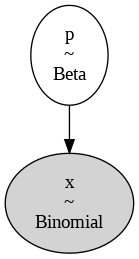

In [6]:
pm.model_to_graphviz(medical_model)

# The two lines below are not needed unless you are on Forum. For
# some reason, it can't display the PDF generated in the line above.
from IPython.display import Image
Image(pm.model_to_graphviz(medical_model).render(format='png'))

## Compute the posterior distribution

PyMC provides two classes of algorithms for approximating the posterior distribution of a model, namely sampling (Markov chain Monte Carlo algorithms) and fitting (variational inference algorithms). We will use both types of algorithms today to get an idea of how they work and explore each type of algorithm in more depth later in the course.

### Approximation 1: Inference by sampling

Sampling algorithms are able to generate random samples from the posterior distribution without actually being able to compute the analytical form (equation) of the posterior PDF.

In theory, sampling algorithms generate samples that really do come from the posterior distribution, _if you give them enough time to run_. Unfortunately, the theory requires "enough time" to mean "forever" before you are guaranteed that the samples really come from the distribution you want.

In practice, the samples are _approximately_ from the correct distribution and the approximation is usually really good. We have some metrics we can monitor to sanity check whether the sampler is behaving as it should but things can go wrong and later we will learn what problems to look out for.

The main drawback of sampling algorithms is that they are slow since they have to run approximately forever to generate accurate samples. The code cell below will take a while to run. Sampling from a PyMC model will feel slow even for simple models.

In [7]:
with medical_model:
    inference = pm.sample()

Output()

**Line 1:**
```python
with medical_model:
```

This line reactivates the model we defined earlier so that Line 2 below which model to sample from. We can define multiple models in one notebook and use this `with` line to activate a particular model.

**Line 2:**
```python
inference = pm.sample()
```

This line runs the default sampler (called the No-U-Turn Sampler, or NUTS) and stores the results in the variable called `inference`.

In [8]:
inference.posterior

<xarray.Dataset> Size: 24kB
Dimensions:  (chain: 2, draw: 1000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    p        (chain, draw) float64 16kB 0.7303 0.7312 0.7312 ... 0.7153 0.7153
Attributes:
    created_at:                 2025-09-09T14:24:06.380271+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    sampling_time:              1.7319235801696777
    tuning_steps:               1000

We don't normally print out the posterior like this but it is helpful to look at it at least once. The `inference.posterior` object contains samples for each of the unknown variables in the model — in this case, that's just the variable $p$. In more complicated models, we will see more variables listed here.

Note that there are multiple "chains" and each chain has multiple "draws". We will learn more about what chains are later in the course. For now, just know that we should use all the values ("draws" — people often talk about drawing a sample from a distribution, hence the name) in all the chains to represent the posterior.

Let's get all those values for $p$ into one array.

In [9]:
all_p_samples = inference.posterior.p.values.flatten()

You should be able to read that line. We get all the values for the $p$ variable from the posterior distribution stored in the `inference` object. The `flatten()` function turns the 2-dimensional array of values (it's a "chains" by "draws" array) into a 1-dimensional array of values.

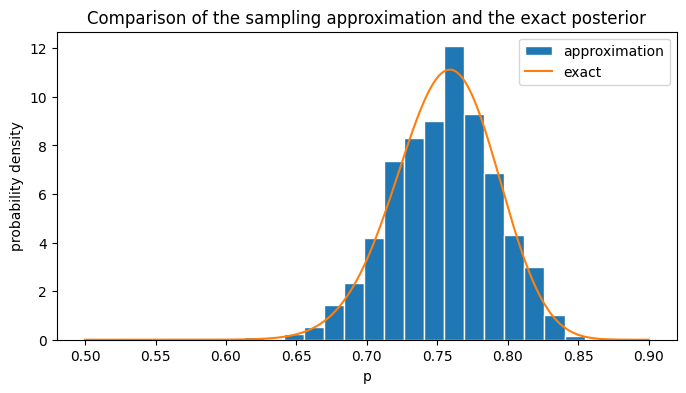

In [10]:
# Plot the samples from the approximate posterior as well as the exact solution
plt.figure(figsize=(8, 4))
plt.title('Comparison of the sampling approximation and the exact posterior')
plt.xlabel('p')
plt.ylabel('probability density')
plt.hist(
    all_p_samples, bins=20, density=True,
    edgecolor='white', label='approximation')
x = np.linspace(0.5, 0.9, 500)
y = sts.beta.pdf(x, 108, 35)
plt.plot(x, y, label='exact')
plt.legend()
plt.show()

If you already know how to use Matplotlib to plot functions and histograms, you can skip this part. If not, read on!

We ran `import matplotlib.pyplot as plt` earlier in this notebook. So, every time we refer to `plt` below it is a reference to the Matplotlib library.

**Lines 2–5:**
```python
plt.figure(figsize=(8, 4))
plt.title('Comparison of the sampling approximation and the exact posterior')
plt.xlabel('p')
plt.ylabel('probability density')
```

These lines create a new, empty figure with a particular size (optional, you don't have to specify a size), give the figure a title, and label the $x$ (horizontal) and $y$ (vertical) axes. **You should always provide titles and labels for your plots.** This is important for making interpretable plots. You will be graded on the #Professionalism LO for your plots.

**Lines 6–8:**
```python
plt.hist(all_p_samples, bins=20, density=True, edgecolor='white', label='approximation')
```

These lines produce a histogram. The `hist()` function will look at the values inside the list or array you provide as the first input and figure out how to bin the data to create the histogram.
* If you want to, you can tell it how many bins you want (we use `bins=20` here) but that is optional.
* The `density=True` argument tells Matplotlib that we want to change the vertical scale of the histogram so that it behaves like a probability density function. This means if you add up the areas (width × height) of all the bars, the total area will be 1 just like a PDF. By default, with `density=False`, the histogram shows counts on the vertical axis — that is, the number of values from the array that fall inside each bin.
* The bars look prettier with white edges, so we have `edgecolor='white'` in there. We can change the color of anything on the plot if we want to. Why do we bother doing this? Because it makes the plot more readable. #Professionalism
* And we give the histogram a label with `label='approximation'`. This is important because there are two plots on that figure — the histogram and the curve of the posterior Beta PDF. We identify them on the plot using labels. #Professionalism

**Lines 9–11:**
```python
x = np.linspace(0.5, 0.9, 500)
y = sts.beta.pdf(x, 108, 35)
plt.plot(x, y, label='exact')
```

These lines produce the curved line. To make line plots, we provide Matplotlib with an array of $x$ coordinates and an array of $y$ coordinates as the first two arguments to the `plot()` function. Matplotlib then draws a line through those coordinates.

Line 9 creates an array of 500 evenly-spaced $x$-coordinates starting at 0.5 on the left and ending at 0.9 on the right. You can see that the orange curve runs from 0.5 to 0.9 on the plot. You can choose to use more or fewer than 500 points. If you use too few, the plot won't look smooth since Matplotlib just connects the $(x,y)$-coordinates with straight line segments. If you use too many, the plot will take longer to produce. A few hundred points are usually fine.

Line 10 creates an array with 500 values containing one $y$-value for each $x$-value, where the $y$-values are computed using the posterior Beta PDF for the treatment group. In this case study, the model is simple enough that we can compute the exact posterior distribution mathematically. We're doing that to check how well the PyMC approximation is doing. In real case studies, we won't be able to compute the posterior mathematically and we won't be able to compare the PyMC approximation to anything like we're doing here.

Line 11 adds the curved line to the same figure, on top of the histogram that is there already. We provide the $x$ and $y$-coordinates and a label.

**Line 12:**
```python
plt.legend()
```

This line turns on the legend. The legend is the box in the top-right corner that contains all the plot labels. If you forget this line, the legend won't appear even if you labeled all your plots.

**Line 13:**
```python
plt.show()
```

This line displays the plot in the notebook.

### Approximation 2: Inference by fitting a function

The basic idea here is that we approximate a complicated function (the posterior) using a simple function. Here, "simple" means it should be easy to generate samples from the approximation and it should be easy to evaluate the PDF of the approximation. For example, PyMC might fit a Normal PDF to the true posterior distribution. The approximation won't be perfect (unless the posterior really is a Normal distribution!) but we have existing algorithms for evaluating the Normal PDF and generating samples from a Normal random variable.

The main advantage of fitting algorithms is that they are fast — much faster than sampling algorithms. This has the benefit that you can iterate much faster on improving your model since you don't have to wait for the inference algorithm to complete. With faster algorithms, you can also generally handle larger data sets in a reasonable amount of time.

The main drawback of fitting algorithms is that we know the answer they produce is wrong — by design. The approximate posterior distribution is just that — an approximation. Samplers have the theoretical guarantee that if we run them for long enough (approximately forever), they will generate samples from the true posterior distribution. Fitting algorithms can never achieve this.

In short, if you want a decent solution fast, use function fitting; if you want an accurate solution and are willing to wait, use sampling.

In [11]:
with medical_model:
    approx = pm.fit()
    inference = approx.sample(4000)

Output()

**Line 1:**
```python
with medical_model:
```

Activate the model.

**Line 2:**
```python
approx = pm.fit()
```

This line runs the default function fitting algorithm (the Automatic Differentiation Variational Inference algorithm, or "ADVI") to fit an approximating PDF to the true posterior distribution.

**Line 3:**
```python
inference = approx.sample(4000)
```

This line generates 4000 samples from the approximating distribution. This is fast since the approximating distribution is simple.

In [ ]:
# Plot the samples from the function fitting posterior as well as the exact solution
plt.figure(figsize=(8, 4))
plt.title('Comparison of the function fitting approximation and the exact posterior')
plt.xlabel('p')
plt.ylabel('probability density')
plt.hist(
    inference.posterior.p.values.flatten(), bins=20, density=True,
    edgecolor='white', label='approximation')
x = np.linspace(0.5, 0.9, 500)
y = sts.beta.pdf(x, 108, 35)
plt.plot(x, y, label='exact')
plt.legend()
plt.show()

## Task

* Reuse (copy-and-paste) the code above to calculate the sampling and function fitting approximations for the **control group**.
* Plot the approximations and histograms and the true Beta() posterior as a curve like we did above. Check how good the approximations are.
* Remember to add your questions or topics for class discussion to the top of this workbook!

In [ ]:
# YOUR WORK GOES HERE
# PASTE THIS CODE INTO THE FORUM PRE-CLASS WORKBOOK WHEN YOU'RE DONE!

## (Optional) Further reading

We used only the Binomial and Beta distributions today but PyMC has many, many distributions predefined. You can view them in [the PyMC documentation](https://www.pymc.io/projects/docs/en/stable/api/distributions.html). Reading this documentation is optional for now. We will cover many of those distributions as we progress through the course. However, if you would like to get started building your own models, the PyMC documentation is an invaluable resource.

The PyMC documentation also contains lots of [example notebooks](https://www.pymc.io/projects/examples/en/latest/gallery.html) that you can use to see how more complicated data analyses are done. Feel free to read ahead if you want to. Most of these notebooks are much more complicated than what we have done so far.